# Content Based 3d Model Retrieval

### Convolutional Neural Networks on 3D models
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

We will be learning on 3D images that are made up of voxels. Simply think pixels, but for 3D.

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

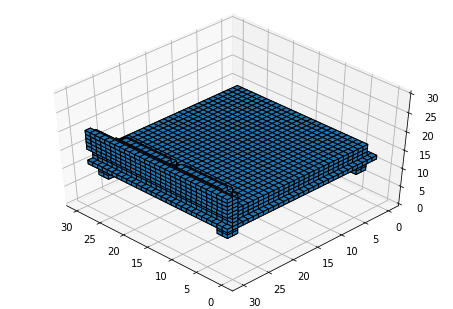

This is a bed.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

## Evaluate class balance for ModelNet10 and ModelNet40

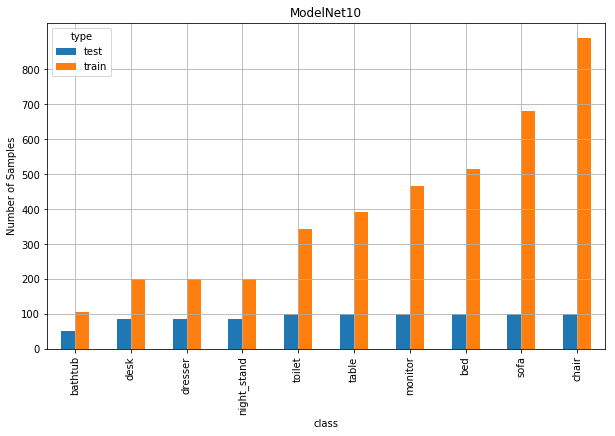

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


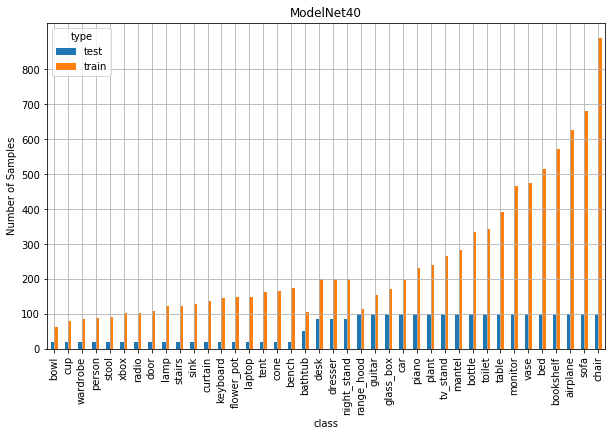

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_unbalanced_classes)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet40')

### Class Balance

class to class imbalance is dealt with using upsampling on **only the training data**

We're using stratified sampling to ensure the validation set is representative of the population.

Please look in the plots module if you'd like to see specifically what is going on to accomplish this.

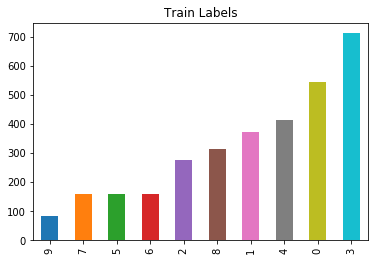

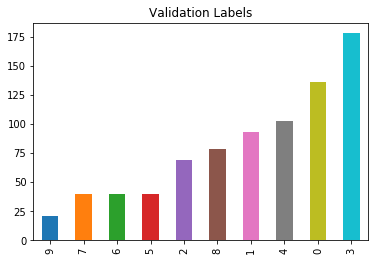

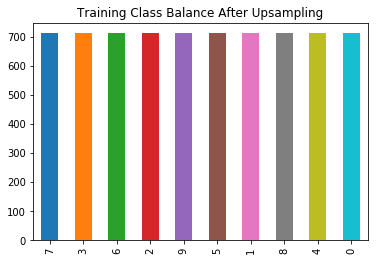

In [2]:
from plots import plot_class_balance
%matplotlib inline

plot_class_balance()

### Build CNN Model
as found in 3DShapeNets paper

In [5]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              4804000   
__________

In [12]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop


model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))




optimizer = SGD(lr=0.01, momentum=.7, decay=1e-5, nesterov=True)
model.summary()
model.compile(optimizer,
              'categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              4804000   
__________

In [15]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=15,
          batch_size=100,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 8000 samples, validate on 400 samples
Epoch 1/15
8000/8000 [==============================] - 22s 3ms/step - loss: 1.1190 - acc: 0.6636 - val_loss: 0.3112 - val_acc: 0.9025

Epoch 00001: val_loss improved from inf to 0.31117, saving model to weights.best.hdf5
Epoch 2/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.2882 - acc: 0.9075 - val_loss: 0.2246 - val_acc: 0.9275

Epoch 00002: val_loss improved from 0.31117 to 0.22457, saving model to weights.best.hdf5
Epoch 3/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1870 - acc: 0.9393 - val_loss: 0.2065 - val_acc: 0.9300

Epoch 00003: val_loss improved from 0.22457 to 0.20647, saving model to weights.best.hdf5
Epoch 4/15
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1355 - acc: 0.9568 - val_loss: 0.1870 - val_acc: 0.9425

Epoch 00004: val_loss improved from 0.20647 to 0.18699, saving model to weights.best.hdf5
Epoch 5/15
8000/8000 [==============================]

[0.6279980300418984, 0.8645374449339207]

There are regularization steps that I'm not able to recreate. 

In [13]:
model.load_weights('./weights.best.hdf5')

In [14]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 1s 1ms/step


[0.3687363857247493, 0.8843612334801763]

# Where CNN is affected by rotation

CNNs aren't pose invariant. See the plots below

Normal vs Rotated by -90 on (1, 2) axes


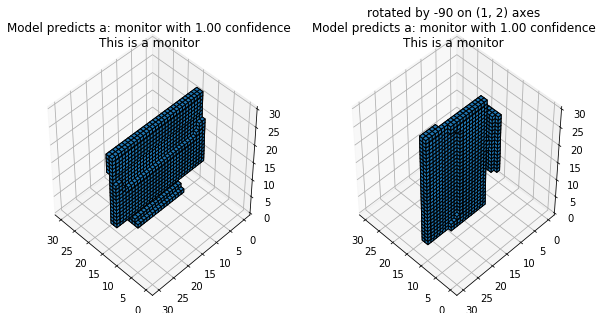

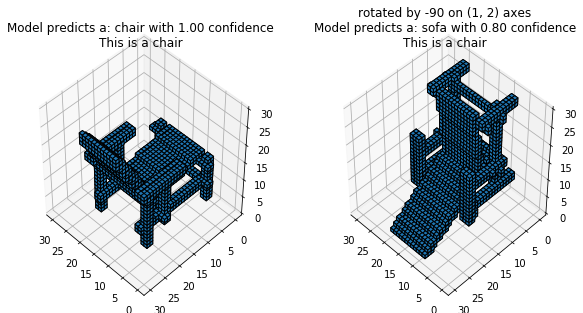

Normal vs Rotated by 90 on (1, 2) axes


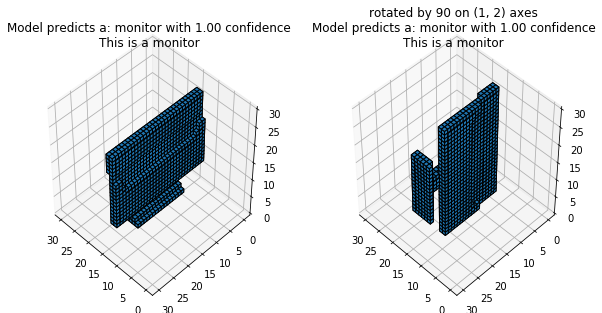

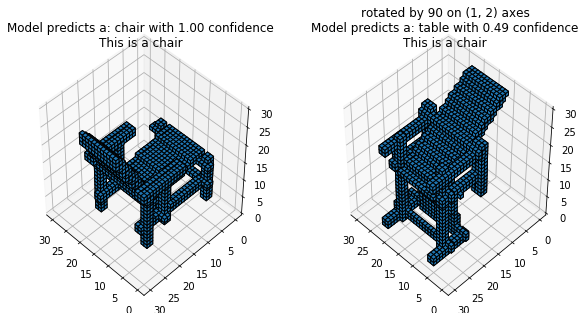

Normal vs Rotated by -90 on (0, 1) axes


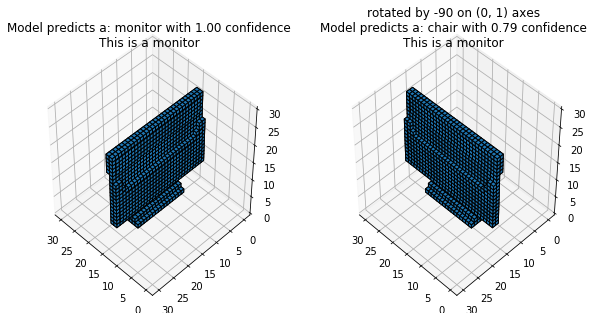

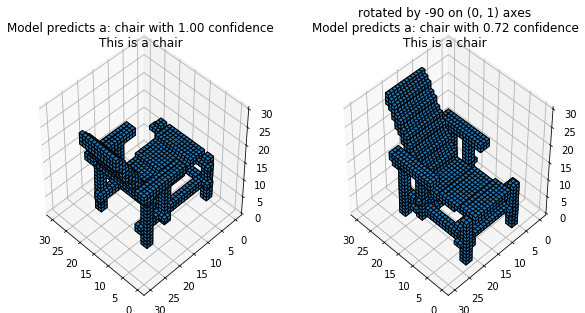

Normal vs Rotated by 90 on (0, 1) axes


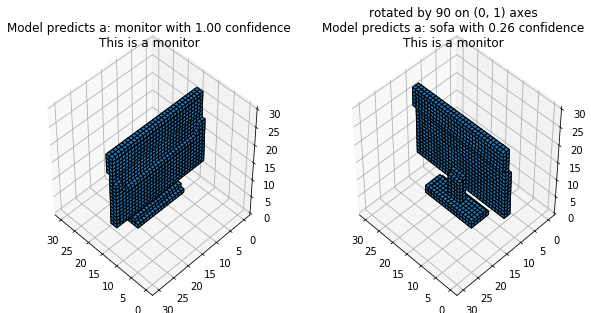

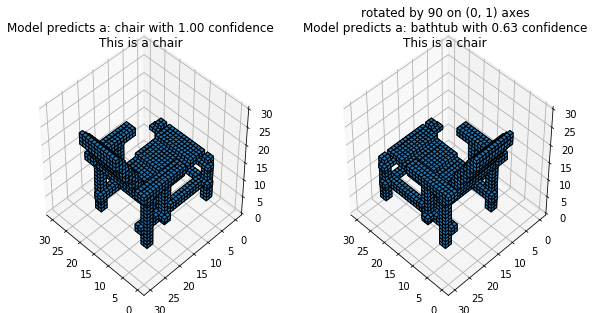

Normal vs Rotated by -90 on (0, 2) axes


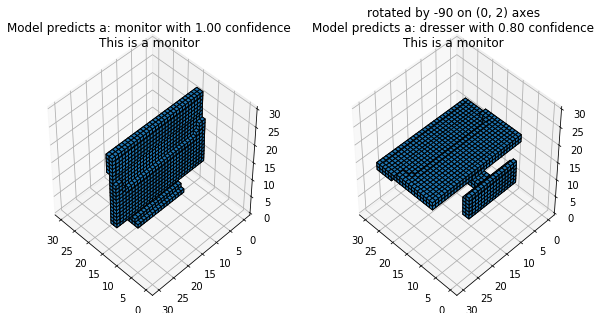

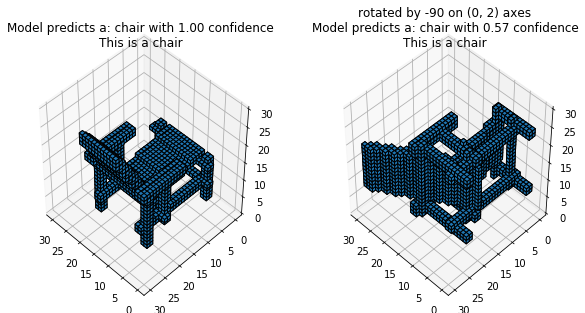

Normal vs Rotated by 90 on (0, 2) axes


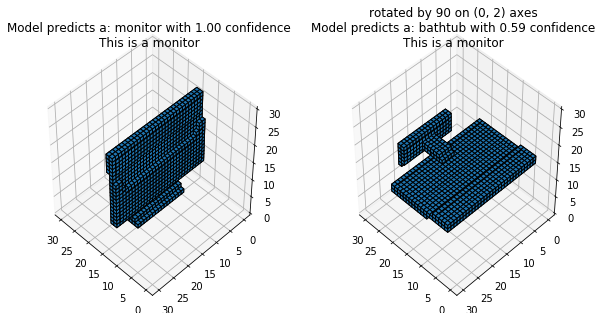

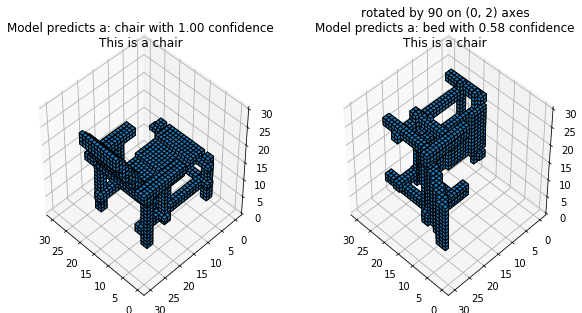

In [14]:
from plots import plot_rotation_issue
poses = [
    (-90, (1, 2)),
    (90, (1, 2)),
    (-90, (0, 1)),
    (90, (0, 1)),
    (-90, (0, 2)),
    (90, (0, 2))
]
for rot, axes in poses:
    print('Normal vs Rotated by {} on {} axes'.format(rot, axes))
    plot_rotation_issue(x_test[100:101], y_test[100],
                        target_names, model, rot, axes)
#     plot_rotation_issue(x_test[300:301], y_test[300],
#                         target_names, model, rot, axes)

You can see that the monitor does ok for axes that keep the majority of the monitor's 'flatness' within the same bounds as the normal model. But, as soon as you rotate it in an axis that pulls the monitor out of the largest bound (the direction when you tip it down onto its face) you see the confidence go way down. 

The same is true for the chair. The chair isn't really necessary in order to see what's happening, but it seems prudent to include it so we know this isn't singular to the monitor model. 

### Time to actually try out Capsule Nets

Now that we've shown that CNNs aren't pose invariant, it's now time to do what we've all been waiting for... IMPLEMENT Capsule Nets!

In [1]:
import numpy as np
import scipy as sp
# from keras import layers, models, optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Conv3D, Dense, Reshape, Add, Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.utils import to_categorical, multi_gpu_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from capsulenet import margin_loss
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

from data import load_data
from plots import (plot_vox,
                   plot_capsnet_rotation_issue,
                   plot_rotation_issue,
                   plot_shaded,
                   plot_dots,
                   plot_recons)
from utils import upsample_classes, stratified_shuffle

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [3]:
n_class = y_test.shape[1]
input_shape = (30, 30, 30, 1)

dim_sub_capsule = 16
dim_primary_capsule = 8
n_channels = 4
primary_cap_kernel_size = 9

first_layer_kernel_size = 9
conv_layer_filters = 48


##### If using multiple GPUS ##########
# with tf.device("/cpu:0"):
x = Input(shape=(30, 30, 30, 1))


conv1 = Conv3D(filters=conv_layer_filters, kernel_size=first_layer_kernel_size, strides=1,
               padding='valid', activation='relu', name='conv1')(x)


# primarycaps = PrimaryCap(conv1, dim_capsule=12, n_channels=32,
#                          kernel_size=9, strides=2, padding='valid')

primarycaps = PrimaryCap(conv1, dim_capsule=dim_primary_capsule, n_channels=n_channels,
                         kernel_size=primary_cap_kernel_size, strides=2, padding='valid',
                         name='primarycap_conv3d')

sub_caps = CapsuleLayer(num_capsule=n_class, dim_capsule=dim_sub_capsule,
                         routings=3, name='sub_caps')(primarycaps)

out_caps = Length(name='capsnet')(sub_caps)

y = Input(shape=(n_class,))
masked_by_y = Mask()([sub_caps, y])

masked = Mask()(sub_caps)

decoder = Sequential(name='decoder')
decoder.add(Dense(512, activation='relu',
                  input_dim=dim_sub_capsule*n_class))
# decoder.add(Dense(64, activation='relu'))
decoder.add(Dense(1024, activation='relu'))
decoder.add(Dense(np.prod(input_shape), activation='sigmoid'))

decoder.add(Reshape(target_shape=input_shape, name='out_recon'))

train_model = Model([x, y], [out_caps, decoder(masked_by_y)])


eval_model = Model(x, [out_caps, decoder(masked)])

### manipulate model
noise = Input(shape=(n_class, dim_sub_capsule))
noised_sub_caps = Add()([sub_caps, noise])
masked_noised_y = Mask()([noised_sub_caps, y])
manipulate_model = Model([x, y, noise], decoder(masked_noised_y))

Instructions for updating:
dim is deprecated, use axis instead


In [8]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30, 30, 30, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 22, 22, 22, 3 23360       input_7[0][0]                    
__________________________________________________________________________________________________
primarycap_conv3d (Conv3D)      (None, 7, 7, 7, 256) 5972224     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 10976, 8)     0           primarycap_conv3d[0][0]          
__________________________________________________________________________________________________
primarycap

##### Train Capsule Net

check num gpus

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2235461705913599400
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 156041216
locality {
  bus_id: 1
}
incarnation: 11089721313345111581
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1d.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 156041216
locality {
  bus_id: 1
}
incarnation: 15738808563258446975
physical_device_desc: "device: 1, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


In [4]:
NUM_EPOCHS = 22
INIT_LR = .0001

optimizer = Adam(lr=INIT_LR)
lam_recon = .04
##### IF USING MULTIPLE GPUS ######
# train_model = multi_gpu_model(train_model, gpus=8) #### Adjust for number of gpus
# train_model = multi_gpu_model(train_model, gpus=2) #### Adjust for number of gpus
##### IF USING MULTIPLE GPUS ######
train_model.compile(optimizer,
                    loss=[margin_loss, 'mse'],
                    loss_weights=[1., lam_recon],
                    metrics={'capsnet': 'accuracy'})

# checkpointer = ModelCheckpoint(filepath='capsnets.rotated.with.non.weights.best.hdf5',
#                                verbose=1, save_best_only=True)
# tb = TensorBoard(log_dir='./capsnet_tensor_board_fourth_pass.log/')
tb = TensorBoard(log_dir='./capsnet_final.log/')

In [5]:
# train_model.fit([x_train, y_train], [y_train, x_train],
#                 batch_size=32, epochs=NUM_EPOCHS,
#                 validation_data=[[x_val, y_val], [y_val, x_val]],
#                 callbacks=[tb])


# TAKE NOTE OF BELOW.  FED IN x_rotated on the LEFT and x_train regular on the RIGHT
train_model.fit([x_train, y_train], [y_train, x_train],
                batch_size=256, epochs=NUM_EPOCHS,
                validation_data=[[x_val, y_val], [y_val, x_val]],
#                 callbacks=[tb, checkpointer])
                callbacks=[tb])

Train on 8000 samples, validate on 400 samples
Epoch 1/22
8000/8000 [==============================] - 96s 12ms/step - loss: 0.6389 - capsnet_loss: 0.6289 - decoder_loss: 0.2499 - capsnet_acc: 0.1814 - val_loss: 0.4565 - val_capsnet_loss: 0.4465 - val_decoder_loss: 0.2498 - val_capsnet_acc: 0.6075
Epoch 2/22
8000/8000 [==============================] - 71s 9ms/step - loss: 0.3627 - capsnet_loss: 0.3527 - decoder_loss: 0.2497 - capsnet_acc: 0.6281 - val_loss: 0.2904 - val_capsnet_loss: 0.2804 - val_decoder_loss: 0.2495 - val_capsnet_acc: 0.7475
Epoch 3/22
8000/8000 [==============================] - 71s 9ms/step - loss: 0.2450 - capsnet_loss: 0.2351 - decoder_loss: 0.2494 - capsnet_acc: 0.7664 - val_loss: 0.1964 - val_capsnet_loss: 0.1864 - val_decoder_loss: 0.2491 - val_capsnet_acc: 0.8600
Epoch 4/22
8000/8000 [==============================] - 71s 9ms/step - loss: 0.1918 - capsnet_loss: 0.1819 - decoder_loss: 0.2489 - capsnet_acc: 0.8095 - val_loss: 0.1590 - val_capsnet_loss: 0.1491 -

KeyboardInterrupt: 

In [17]:
y_pred, x_recon = eval_model.predict(x_test)

In [7]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

0.8105726872246696

In [27]:
str(100*round(np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0], 5)).replace('.','')

'81057'

for loading with custom layers

https://github.com/keras-team/keras/issues/4871

https://github.com/keunwoochoi/kapre

In [32]:
train_model.save_weights('capsnets.modelnet10.hdf5')

In [8]:
train_model.save('test.hdf5')

In [8]:
eval_model.save('eval.hdf5')

In [16]:
eval_model.save_weights('eval_model_weights.hdf5')

In [11]:
import pickle

In [13]:
with open('config', 'wb') as f:
    pickle.dump(train_model.get_config(), f)

In [ ]:
train_model.save_weights()

'model_2'

In [5]:
from keras.models import load_model
from keras.utils import CustomObjectScope
from capsulenet import margin_loss
from capsulelayers import CapsuleLayer, Mask, Length

with CustomObjectScope({'CapsuleLayer': CapsuleLayer, 'Mask':Mask,
                        'Length':Length, 'margin_loss':margin_loss}):
    eval_model = load_model('eval.hdf5')

Instructions for updating:
dim is deprecated, use axis instead


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
y_pred, x_recon = eval_model.predict(x_test)

In [7]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.8105726872246696


In [3]:
from data import load_custom_model

In [4]:
eval_model = load_custom_model('eval.hdf5')

Instructions for updating:
dim is deprecated, use axis instead


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
y_pred, x_recon = eval_model.predict(x_test)

In [6]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.8105726872246696


Should be close to 85% (checking this whenever starting up)

# Final Pass

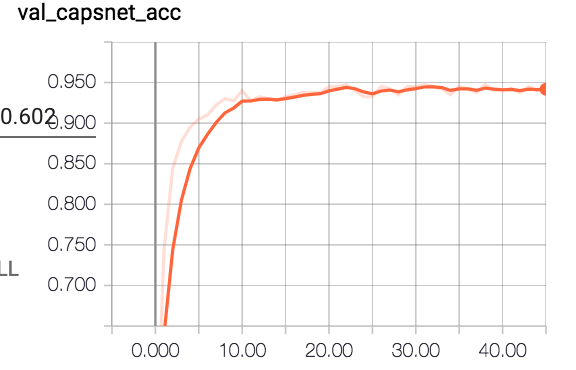

It was discovered that the optimal val_acc was at step 22. Since I didn't use early stop, just going to run until epoch 22 and save. (checkpointing doesn't work on multiple gpus, I don't know why)

# What's my accuracy against randomly rotated test data (with weights from eleventh pass)?

In [4]:
def rotate_randomly(arr):
    return sp.ndimage.interpolation.rotate(np.rot90(arr,
                                                    k=np.random.choice([0, 1]),
                                                    axes=np.random.choice(range(0, 3), 2, False)),
                                           np.random.choice(range(0, 45)),
                                           axes=(np.random.choice(range(0, 3), 2, False)),
                                           reshape=False)



In [ ]:
x_rotated = np.array([rotate_randomly(arr) for arr in x_train])

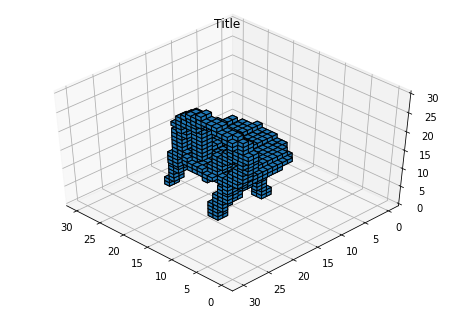

In [42]:
plot_vox(x_rotated[2].reshape(30, 30, 30))

In [7]:
train_model.load_weights('capsnets.rotated.with.non.weights.best.hdf5')

In [13]:
x_test_rotated = np.array([rotate_randomly(arr) for arr in x_test])

In [14]:
y_pred, x_recon = eval_model.predict(x_test_rotated)

In [15]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.670704845814978
